# k-Nearest Neighbor (kNN)
In this notebook we will use the K-Nearest Neighbor (KNN) algorithm to classify the species of iris flowers, given measurements of flower characteristics.

Steps for data preparation:
1. Data exploration, data preparation, modeling, and model evaluation.

***

The goal is to train a model to produceuseful response to the input. The response is a typical prediction of something we want to know abut the data.

    + knn methods do no require training.
    + A new case is clasdified based on proximity to labeled cases, using a distance metric.

## Examination the data

We will work with the Iris data set. This data set is famous in the history of statistics. The first publication using these data in statistics by the pioneering statistician Ronald A Fisher was in 1936. 

Lets first load and examine these data which are in the statsmodels.api package. 

Execute the code in the cell below and examine the first few rows of the data frame. 

In [1]:

"""
*
*  @details
*   Execute the code in the cell below and examine the first few rows of the data frame. 
*
*  @param    N/A.
*  @return   create a dataframe from the dictionary.
"""


import pandas as pd
#from statsmodels.api import datasets
from sklearn import datasets ## Get dataset from sklearn

## Import the dataset from sklearn.datasets
iris = datasets.load_iris()

## Create a data frame from the dictionary
species = [iris.target_names[x] for x in iris.target]
iris = pd.DataFrame(iris['data'], columns = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'])
iris['Species'] = species


There are four features, containing the dimensions of parts of the iris flower structures. The label column is the Species of the flower. The goal is to create and test a KNN algorithm to correctly classify the species. 


In [3]:
iris.dtypes #to show the data types of each column. 

Sepal_Length    float64
Sepal_Width     float64
Petal_Length    float64
Petal_Width     float64
Species          object
dtype: object

The features are all numeric, and the label is a categorical string variable.

In [4]:
# Next, you will determine the number of unique categories, and number of cases for each category, 
# for the label variable, Species. Execute the code in the cell below and examine the results. 

iris['count'] = 1
iris[['Species', 'count']].groupby('Species').count()

count
Species          
setosa         50
versicolor     50
virginica      50

You can see there are three species of iris, each with 50 cases. 

Next, you will create some plots to see how the classes might, or might not, be well separated by the value of the features. In an ideal case, the label classes will be perfectly separated by one or more of the feature pairs. In the real-world this ideal situation will rarely, if ever, be the case.
 
There are six possible pair-wise scatter plots of these four features. For now, we will just create scatter plots of two variable pairs. Execute the code in the cell below and examine the resulting plots.
***
**Note:** Data visualization and the Seaborn package are covered in another lesson.
***

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


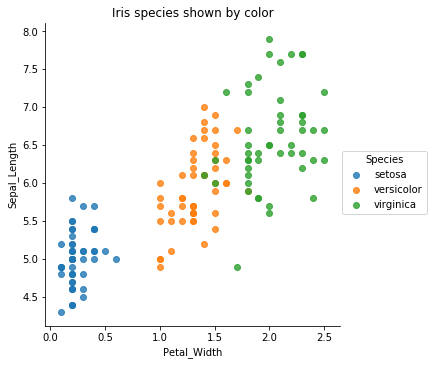

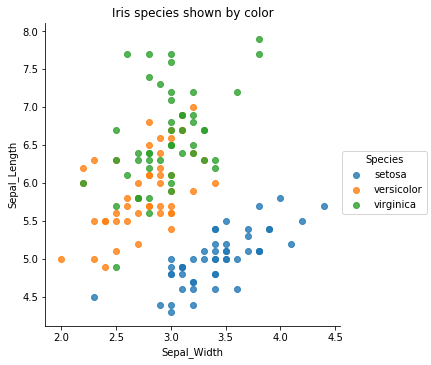

In [5]:
%matplotlib inline
def plot_iris(iris, col1, col2):
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.lmplot(x = col1, y = col2, 
               data = iris, 
               hue = "Species", 
               fit_reg = False)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('Iris species shown by color')
    plt.show()
plot_iris(iris, 'Petal_Width', 'Sepal_Length')
plot_iris(iris, 'Sepal_Width', 'Sepal_Length')

## Prepare the data set

Data preparation is an important step before training any machine learning model. These data require only two preparation steps:
- Scale the numeric values of the features. It is important that numeric features used to train machine learning models have a similar range of values. Otherwise, features which happen to have large numeric values may dominate model training, even if other features with smaller numeric values are more informative. In this case Zscore normalization is used. This normalization process scales each feature so that the mean is 0 and the variance is 1.0. 
- Split the dataset into randomly sampled training and evaluation data sets. The random selection of cases seeks to limit the leakage of information between the training and evaluation cases.

The code in the cell below normalizes the features by these steps:
- The scale function from scikit-learn.preprocessing is used to normalize the features.
- Column names are assigned to the resulting data frame. 
- A statitical summary of the data frame is then printed. 


In [6]:
from sklearn.preprocessing import scale
import pandas as pd
num_cols = ['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width']
iris_scaled = scale(iris[num_cols])
iris_scaled = pd.DataFrame(iris_scaled, columns = num_cols)
print(iris_scaled.describe().round(3))

       Sepal_Length  Sepal_Width  Petal_Length  Petal_Width
count       150.000      150.000       150.000      150.000
mean         -0.000       -0.000        -0.000       -0.000
std           1.003        1.003         1.003        1.003
min          -1.870       -2.439        -1.569       -1.444
25%          -0.901       -0.588        -1.228       -1.182
50%          -0.053       -0.125         0.336        0.133
75%           0.675        0.569         0.763        0.791
max           2.492        3.115         1.786        1.711


The mean of each column is zero and the standard deviation is approximately 1.0.

The methods in the scikit-learn package requires numeric numpy arrays as arguments. Therefore, the strings indicting species must be re-coded as numbers.

In [7]:
## The code in the cell below does this using a dictionary lookup. 
## Execute this code and examine the head of the data frame. 
levels = {'setosa':0, 'versicolor':1, 'virginica':2}
iris_scaled['Species'] = [levels[x] for x in iris['Species']]
iris_scaled.head()

Sepal_Length  Sepal_Width  Petal_Length  Petal_Width  Species
0     -0.900681     1.032057     -1.341272    -1.312977        0
1     -1.143017    -0.124958     -1.341272    -1.312977        0
2     -1.385353     0.337848     -1.398138    -1.312977        0
3     -1.506521     0.106445     -1.284407    -1.312977        0
4     -1.021849     1.263460     -1.341272    -1.312977        0

Now, you will split the dataset into a test and evaluation sub-sets. The code in the cell below randomly splits the dataset into training and testing subsets. The features and labels are then separated into numpy arrays. The dimension of each array is printed as a check. Execute this code to create these subsets. 

In [8]:
## Split the data into a training and test set by Bernoulli sampling
from sklearn.model_selection import train_test_split
import numpy as np
np.random.seed(3456)
iris_split = train_test_split(np.asmatrix(iris_scaled), test_size = 75)
iris_train_features = iris_split[0][:, :4]
iris_train_labels = np.ravel(iris_split[0][:, 4])
iris_test_features = iris_split[1][:, :4]
iris_test_labels = np.ravel(iris_split[1][:, 4])
print(iris_train_features.shape)
print(iris_train_labels.shape)
print(iris_test_features.shape)
print(iris_test_labels.shape)

(75, 4)
(75,)
(75, 4)
(75,)


## Train and evaluate the KNN model

With some understanding of the relationships between the features and the label and preparation of the data completed you will now train and evaluate a $K = 3$ model. The code in the cell below does the following:
- The KNN model is defined as having $K = 3$.
- The model is trained using the fit method with the feature and label numpy arrays as arguments.
- Displays a summary of the model. 


In [9]:
## Define and train the KNN model
from sklearn.neighbors import KNeighborsClassifier
KNN_mod = KNeighborsClassifier(n_neighbors = 3)
KNN_mod.fit(iris_train_features, iris_train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Next, you will evaluate this model using the accuracy statistic and a set of plots. The following steps create model predictions and compute accuracy:
- The predict method is used to compute KNN predictions from the model using the test features as an argument. 
- The predictions are scored as correct or not using a list comprehension. 
- Accuracy is computed as the percentage of the test cases correctly classified. 


In [10]:
iris_test = pd.DataFrame(iris_test_features, columns = num_cols)
iris_test['predicted'] = KNN_mod.predict(iris_test_features)
iris_test['correct'] = [1 if x == z else 0 for x, z in zip(iris_test['predicted'], iris_test_labels)]
accuracy = 100.0 * float(sum(iris_test['correct'])) / float(iris_test.shape[0])
print(accuracy)

96.0


The accuracy is pretty good.

Now, execute the code in the cell below and examine plots of the classifications of the iris species. 

'Done'

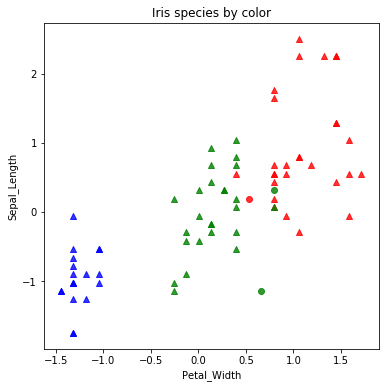

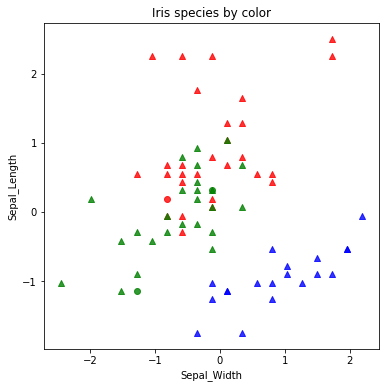

In [11]:
levels = {0:'setosa', 1:'versicolor', 2:'virginica'}
iris_test['Species'] = [levels[x] for x in iris_test['predicted']]
markers = {1:'^', 0:'o'}
colors = {'setosa':'blue', 'versicolor':'green', 'virginica':'red'}
def plot_shapes(df, col1,col2,  markers, colors):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ax = plt.figure(figsize=(6, 6)).gca() # define plot axis
    for m in markers: # iterate over marker dictioary keys
        for c in colors: # iterate over color dictionary keys
            df_temp = df[(df['correct'] == m)  & (df['Species'] == c)]
            sns.regplot(x = col1, y = col2, 
                        data = df_temp,  
                        fit_reg = False, 
                        scatter_kws={'color': colors[c]},
                        marker = markers[m],
                        ax = ax)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('Iris species by color')
    return 'Done'
plot_shapes(iris_test, 'Petal_Width', 'Sepal_Length', markers, colors)
plot_shapes(iris_test, 'Sepal_Width', 'Sepal_Length', markers, colors)

In the plots above color is used to show the predicted class. Correctly classified cases are shown by triangles and incorrectly classified cases are shown by circles. 

## Overview

In this exercice we created and evaluated a KNN machine learning classification model. Specifically you have:
1. Loaded and explored the data using visualization to determine if the features separate the classes.
2. Prepared the data by normalizing the numeric features and randomly sampling into training and testing subsets. 
3. Constructing and evaluating the machine learning model. Evaluation was performed by statistically, with the accuracy metric, and with visualization. 